##Llama2 Production

SUMA 26/09/2023

#Instructions

Running code on Google Colab
1.   Create HuggingFace account
2.   Gain access to model: https://huggingface.co/meta-llama/Llama-2-7b-chat-hf
3.   Create folder 'data' in project folder on personal Google Drive
4.   Save data set CrisiLexT26 in folder 'data'
5.   Data sourced from: https://crisislex.org/data-collections.html#CrisisLexT26
6.   Mount Google Drive
7.   Update code with Paths
8.   Set system up as per steps below
9.   Run Experiments
10.  Evaluate

## Setup

In [1]:
# Install Transformer package
!pip install -q transformers einops accelerate langchain bitsandbytes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 28.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 28.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 49.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 33.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 91.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 81.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.0/40.0 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 24.5 MB/s eta 0:00:00


In [2]:
# Import Packages
from langchain import PromptTemplate,  LLMChain
from langchain import HuggingFacePipeline
from transformers import AutoTokenizer
import transformers
import torch
import pandas as pd
import numpy as np
import json
import os
import csv
import time
import re
import matplotlib.pyplot as plt
import json



In [3]:
# Mounting GDrive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### Prerequisites

To load our desired model, `meta-llama/Llama-2-7b-chat-hf`, we first need to authenticate ourselves on Hugging Face. This ensures we have the correct permissions to fetch the model.

1. Gain access to the model on Hugging Face: [Link](https://huggingface.co/meta-llama/Llama-2-7b-chat-hf).
2. Use the Hugging Face CLI to login and verify your authentication status.


In [4]:
# Logging onto HuggingFace
!huggingface-cli login



    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|
    
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) n
Token is valid (permission: read).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [5]:
!pip install sentencepiece


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 10.7 MB/s eta 0:00:00


## Preparing data

In [6]:
# Read (timestamps)

# Path to the main folder
main_folder = '/content/gdrive/MyDrive/iLab2/data/CrisisLexT26'

# Function to process CSV files in a folder
def process_folder(folder_path):
    dfs = []
    for root, _, files in os.walk(folder_path):
        for file in files:
            if file.endswith('.csv') and 'period' in file.lower():
                file_path = os.path.join(root, file)
                df = pd.read_csv(file_path)
                dfs.append(df)
    return dfs

# Read and process each subfolder
combined_data = []
for subfolder in os.listdir(main_folder):
    subfolder_path = os.path.join(main_folder, subfolder)
    if os.path.isdir(subfolder_path):
        subfolder_data = process_folder(subfolder_path)
        combined_data.extend(subfolder_data)

# Concatenate all data into one DataFrame
combined_df_p = pd.concat(combined_data, ignore_index=True)


# Remove spaces from column names
combined_df_p.columns = combined_df_p.columns.str.replace(' ', '')

# Rename Columns in prep for left join
combined_df_p.rename(columns={'Tweet-ID': 'Tweet ID'}, inplace=True)

# # Save the combined DataFrame to a CSV file
# output_file = 'combined_data.csv'
# combined_df.to_csv(output_file, index=False)

print(f"Combined timestamps read")


Combined timestamps read


In [7]:
# Read tweets

# Path to the main folder
main_folder = '/content/gdrive/MyDrive/iLab2/data/CrisisLexT26'

# Function to process CSV files in a folder, add folder name as label, and add subfolder name as a column
def process_folder(folder_path, label, subfolder_name):
    dfs = []
    for root, _, files in os.walk(folder_path):
        for file in files:
            if file.endswith('.csv') and 'labeled' in file.lower():
                file_path = os.path.join(root, file)
                df = pd.read_csv(file_path)
                df['Label'] = label
                df['subfolder_name'] = subfolder_name  # Add subfolder name as a column
                dfs.append(df)
    return dfs

# Read and process each subfolder
combined_data = []
for subfolder in os.listdir(main_folder):
    subfolder_path = os.path.join(main_folder, subfolder)
    if os.path.isdir(subfolder_path):
        label = subfolder
        subfolder_data = process_folder(subfolder_path, label, subfolder)
        combined_data.extend(subfolder_data)

# Concatenate all data into one DataFrame
combined_df_l = pd.concat(combined_data, ignore_index=True)

# Print the first few rows of the combined DataFrame
print(f"Combined tweets read")
combined_df_l.head(10)


Combined tweets read


,Tweet ID,Tweet Text,Information Source,Information Type,Informativeness,Label,subfolder_name
0,242883454050648064,"#earthquake M 3.3, Virgin Islands region: Sept...",Not labeled,Not labeled,Not related,2012_Costa_Rica_earthquake,2012_Costa_Rica_earthquake
1,242887379944366080,@EarthquakeTest update your #earthquake s more,Not labeled,Not labeled,Not related,2012_Costa_Rica_earthquake,2012_Costa_Rica_earthquake
2,242919634125328384,"RT @RedazioneWebAL: #Terremoto, Costi (Pd): ta...",Not labeled,Not labeled,Not related,2012_Costa_Rica_earthquake,2012_Costa_Rica_earthquake
3,242920737223106561,"#Earthquake M 2.6, Southern Alaska http://t.co...",Not labeled,Not labeled,Not related,2012_Costa_Rica_earthquake,2012_Costa_Rica_earthquake
4,242936558158757889,５年６ヶ月長期保存可能なえいようかん5本。http://t.co/ZlSVctfi #eqj...,Not labeled,Not labeled,Not applicable,2012_Costa_Rica_earthquake,2012_Costa_Rica_earthquake
5,242945299084103681,#earthquake sige najud ug linug diri ui.. =.=,Not labeled,Not labeled,Not applicable,2012_Costa_Rica_earthquake,2012_Costa_Rica_earthquake
6,242950005076393985,@MRmusica pasenla super bien :) Mil besos desd...,Not labeled,Not labeled,Not related,2012_Costa_Rica_earthquake,2012_Costa_Rica_earthquake
7,242951548576088065,RT @TerreInMoto: I Negozi di Mirandola 3 Mesi ...,Not labeled,Not labeled,Not related,2012_Costa_Rica_earthquake,2012_Costa_Rica_earthquake
8,242979541373562880,#earthquake Philippines (the): NDRRMC Update r...,Not labeled,Not labeled,Not related,2012_Costa_Rica_earthquake,2012_Costa_Rica_earthquake
9,242997841134505985,"【#USGS #Breaking】 M 1.1, 28km SSW of Fairbanks...",Not labeled,Not labeled,Not applicable,2012_Costa_Rica_earthquake,2012_Costa_Rica_earthquake


In [8]:
# Check
combined_df_p.columns
combined_df_p.head()


,Timestamp,Tweet ID,Included(Y/N)
0,Sun Sep 16 06:07:51 +0000 2012,247215201198436352,Y
1,Sun Sep 16 06:08:01 +0000 2012,247215243137257472,Y
2,Sun Sep 16 06:10:16 +0000 2012,247215809372516353,Y
3,Sun Sep 16 06:39:34 +0000 2012,247223182979911681,Y
4,Sun Sep 16 06:41:20 +0000 2012,247223627584520192,Y


In [9]:
# Extract earliest timestamp

# Convert it to datetime first
combined_df_p['Timestamp'] = pd.to_datetime(combined_df_p['Timestamp'])

# Group by 'Tweet-ID' and aggregate to find the earliest timestamp
earliest_timestamps = combined_df_p.groupby('Tweet ID')['Timestamp'].agg('min').reset_index()

# Display or use the resulting DataFrame 'earliest_timestamps'
# print(earliest_timestamps)

In [10]:
# Left join

# Perform a left join on 'Tweet ID'
result_df = combined_df_l.merge(earliest_timestamps, on='Tweet ID', how='left')

# Display
# print(result_df)
# result_df.shape
result_df.head()

,Tweet ID,Tweet Text,Information Source,Information Type,Informativeness,Label,subfolder_name,Timestamp
0,242883454050648064,"#earthquake M 3.3, Virgin Islands region: Sept...",Not labeled,Not labeled,Not related,2012_Costa_Rica_earthquake,2012_Costa_Rica_earthquake,2012-09-04 07:15:02+00:00
1,242887379944366080,@EarthquakeTest update your #earthquake s more,Not labeled,Not labeled,Not related,2012_Costa_Rica_earthquake,2012_Costa_Rica_earthquake,2012-09-04 07:30:38+00:00
2,242919634125328384,"RT @RedazioneWebAL: #Terremoto, Costi (Pd): ta...",Not labeled,Not labeled,Not related,2012_Costa_Rica_earthquake,2012_Costa_Rica_earthquake,2012-09-04 09:38:48+00:00
3,242920737223106561,"#Earthquake M 2.6, Southern Alaska http://t.co...",Not labeled,Not labeled,Not related,2012_Costa_Rica_earthquake,2012_Costa_Rica_earthquake,2012-09-04 09:43:11+00:00
4,242936558158757889,５年６ヶ月長期保存可能なえいようかん5本。http://t.co/ZlSVctfi #eqj...,Not labeled,Not labeled,Not applicable,2012_Costa_Rica_earthquake,2012_Costa_Rica_earthquake,2012-09-04 10:46:03+00:00


In [11]:
# Read

# Define the main folder path
main_folder = '/content/gdrive/MyDrive/iLab2/data/CrisisLexT26'

# Initialize empty lists to store the extracted data
subfolder_names = []
names = []
start_days = []
durations = []
countries = []
location_descriptions = []
sub_categories = []
types = []

# Loop through the subfolders
for subfolder in os.listdir(main_folder):
    subfolder_path = os.path.join(main_folder, subfolder)

    # Check if it's a directory
    if os.path.isdir(subfolder_path):
        json_files = [f for f in os.listdir(subfolder_path) if f.endswith('.json')]

        # Loop through JSON files in the subfolder
        for json_file in json_files:
            json_path = os.path.join(subfolder_path, json_file)

            # Read the JSON file
            with open(json_path, 'r') as f:
                data = json.load(f)

                # Extract the required information
                subfolder_names.append(subfolder)
                names.append(data['name'])
                start_days.append(data['time']['start_day'])
                durations.append(data['time']['duration'])
                countries.append(data['location']['country'])
                location_descriptions.append(data['location']['location_description'])
                sub_categories.append(data['categorization']['sub_category'])
                types.append(data['categorization']['type'])

# Create a DataFrame from the extracted data
df_annotation = pd.DataFrame({
    'subfolder_name': subfolder_names,
    'name': names,
    'start_day': start_days,
    'duration': durations,
    'country': countries,
    'location_description': location_descriptions,
    'sub_category': sub_categories,
    'type': types
})

# Display the DataFrame
df_annotation.head()


,subfolder_name,name,start_day,duration,country,location_description,sub_category,type
0,2012_Costa_Rica_earthquake,Costa Rica earthquake,2012-09-04,13,Costa Rica,Costa Rica,Geophysical,Earthquake
1,2012_Venezuela_refinery,Venezuela refinery explosion,2012-08-24,12,Venezuela,Falcon,Unintentional,Explosion
2,2013_Alberta_floods,Alberta Floods,17/06/2013,25,Canada,Alberta,Hydrological,Floods
3,2013_Australia_bushfire,Australia wildfires,2013-10-12,21,Australia,New South Wales,Climatological,Wildfire
4,2012_Guatemala_earthquake,Guatemala earthquake,2012-11-06,20,Guatemala,Guatemala,Geophysical,Earthquake


In [12]:
# Left join

# Perform a left join on the 'subfolder'
result_df = result_df.merge(df_annotation, left_on='subfolder_name', right_on='subfolder_name', how='left')

# Drop the duplicate 'subfolder_name'
result_df.drop(columns=['subfolder_name'], inplace=True)


In [13]:
# Count the number of rows in result_df
row_count = result_df.shape[0]

# Print the row count
print(f"Number of rows in result_df: {row_count}")

result_df.head()


Number of rows in result_df: 27933


,Tweet ID,Tweet Text,Information Source,Information Type,Informativeness,Label,Timestamp,name,start_day,duration,country,location_description,sub_category,type
0,242883454050648064,"#earthquake M 3.3, Virgin Islands region: Sept...",Not labeled,Not labeled,Not related,2012_Costa_Rica_earthquake,2012-09-04 07:15:02+00:00,Costa Rica earthquake,2012-09-04,13,Costa Rica,Costa Rica,Geophysical,Earthquake
1,242887379944366080,@EarthquakeTest update your #earthquake s more,Not labeled,Not labeled,Not related,2012_Costa_Rica_earthquake,2012-09-04 07:30:38+00:00,Costa Rica earthquake,2012-09-04,13,Costa Rica,Costa Rica,Geophysical,Earthquake
2,242919634125328384,"RT @RedazioneWebAL: #Terremoto, Costi (Pd): ta...",Not labeled,Not labeled,Not related,2012_Costa_Rica_earthquake,2012-09-04 09:38:48+00:00,Costa Rica earthquake,2012-09-04,13,Costa Rica,Costa Rica,Geophysical,Earthquake
3,242920737223106561,"#Earthquake M 2.6, Southern Alaska http://t.co...",Not labeled,Not labeled,Not related,2012_Costa_Rica_earthquake,2012-09-04 09:43:11+00:00,Costa Rica earthquake,2012-09-04,13,Costa Rica,Costa Rica,Geophysical,Earthquake
4,242936558158757889,５年６ヶ月長期保存可能なえいようかん5本。http://t.co/ZlSVctfi #eqj...,Not labeled,Not labeled,Not applicable,2012_Costa_Rica_earthquake,2012-09-04 10:46:03+00:00,Costa Rica earthquake,2012-09-04,13,Costa Rica,Costa Rica,Geophysical,Earthquake


## Modeling

In [14]:
# Tokenizer
model = "meta-llama/Llama-2-7b-chat-hf"

tokenizer = AutoTokenizer.from_pretrained(model)

pipeline = transformers.pipeline(
    "text-generation", #task
    model=model,
    tokenizer=tokenizer,
    torch_dtype=torch.bfloat16,
    trust_remote_code=True,
    device_map="auto",
    max_length=1000,
    do_sample=True,
    top_k=10,

    num_return_sequences=1,
    eos_token_id=tokenizer.eos_token_id
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [15]:
# Load model
llm = HuggingFacePipeline(pipeline = pipeline, model_kwargs = {'temperature':0})


In [16]:
# Prompt Template Formatting
B_INST, E_INST = "[INST]", "[/INST]"
B_SYS, E_SYS = "<>\n", "\n<>\n\n"
DEFAULT_SYSTEM_PROMPT = """\
You are a helpful, respectful and honest assistant. Always answer as helpfully as possible, while being safe. Your answers should not include any harmful, unethical, racist, sexist, toxic, dangerous, or illegal content. Please ensure that your responses are socially unbiased and positive in nature.

If a question does not make any sense, or is not factually coherent, explain why instead of answering something not correct. If you don't know the answer to a question, please don't share false information."""

def get_prompt(instruction, new_system_prompt=DEFAULT_SYSTEM_PROMPT ):
    SYSTEM_PROMPT = B_SYS + new_system_prompt + E_SYS
    prompt_template =  B_INST + SYSTEM_PROMPT + instruction + E_INST
    return prompt_template

def parse_text(text):
        wrapped_text = textwrap.fill(text, width=100)
        print(wrapped_text +'\n\n')
        # return assistant_text

In [17]:
def generate_answer(text, system_prompt, instruction):
  prompt_template = get_prompt(instruction, system_prompt)
  prompt = PromptTemplate(template=prompt_template, input_variables= ['text'])
  llm_chain = LLMChain(prompt=prompt, llm=llm)
  text = llm_chain.run(text)
  return text

In [55]:
# Grab 20 random samples
filtered_df = result_df.query("Label == '2012_Colorado_wildfires'")

testing_df = filtered_df.sample(n=100, random_state=42)
testing_df.columns = testing_df.columns.str.replace(' ', '')

testing_df['TweetText'] = testing_df['TweetText'].astype(str)
# Filter for TweetText string greater than 5 words excluding words starting with "@"" and "http"
testing_df = testing_df[testing_df['TweetText'].str.split().apply(lambda x: sum(1 for word in x if not word.startswith('@') and not word.startswith('http') and not word.startswith('#') )) > 5]
testing_df.head(20)


,TweetID,TweetText,InformationSource,InformationType,Informativeness,Label,Timestamp,name,start_day,duration,country,location_description,sub_category,type
8839,221503954108940290,PetMeds Joins Efforts to Help Pets Affected by...,Media,Donations and volunteering,Related and informative,2012_Colorado_wildfires,2012-07-07 07:20:32+00:00,Colorado wildfires,2012-06-08,31,US,Colorado,Climatological,Wildfire
8526,218318321509085185,Federal firefighters go uninsured: As brutal w...,Outsiders,Other Useful Information,Related and informative,2012_Colorado_wildfires,2012-06-28 12:21:58+00:00,Colorado wildfires,2012-06-08,31,US,Colorado,Climatological,Wildfire
7762,212412775027314690,So proud of the Colorado Springs Air Force gra...,Not labeled,Not labeled,Not related,2012_Colorado_wildfires,2012-06-12 05:15:26+00:00,Colorado wildfires,2012-06-08,31,US,Colorado,Climatological,Wildfire
8100,217406194590035968,I couldn't remember what happened to R.J. on #...,Not labeled,Not labeled,Not related,2012_Colorado_wildfires,2012-06-25 23:57:30+00:00,Colorado wildfires,2012-06-08,31,US,Colorado,Climatological,Wildfire
8781,220307872813285376,Anti-Tax movement region of Colorado hit by fi...,Media,Other Useful Information,Related and informative,2012_Colorado_wildfires,2012-07-04 00:07:44+00:00,Colorado wildfires,2012-06-08,31,US,Colorado,Climatological,Wildfire
7984,215821620097462272,USFS forest ecologist: Not just forests out of...,Government,Other Useful Information,Related and informative,2012_Colorado_wildfires,2012-06-21 15:00:58+00:00,Colorado wildfires,2012-06-08,31,US,Colorado,Climatological,Wildfire
8635,218692809920749572,Colorado Fire Relief benefit concerts at Red R...,NGOs,Donations and volunteering,Related and informative,2012_Colorado_wildfires,2012-06-29 13:10:03+00:00,Colorado wildfires,2012-06-08,31,US,Colorado,Climatological,Wildfire
8072,217059048850325504,"Lady, in her favorite perch above the backyard...",Not labeled,Not labeled,Not related,2012_Colorado_wildfires,2012-06-25 00:58:04+00:00,Colorado wildfires,2012-06-08,31,US,Colorado,Climatological,Wildfire
8516,218229725229887488,@KleinErin seems there are heaps of plane issu...,Outsiders,Other Useful Information,Related and informative,2012_Colorado_wildfires,2012-06-28 06:29:55+00:00,Colorado wildfires,2012-06-08,31,US,Colorado,Climatological,Wildfire
8481,218150272508235777,RT @tryonb: Chapel Hills Mall in Colorado Spri...,Business,Other Useful Information,Related and informative,2012_Colorado_wildfires,2012-06-28 01:14:12+00:00,Colorado wildfires,2012-06-08,31,US,Colorado,Climatological,Wildfire


In [56]:
# Running over data v1 [with explination] [remove   Return in max 3 words.]  [return label in quotation] [incl war, natural disasters] 15 best because some in quoteation and some in label format

system_prompt = "You are an advance assistant that excels at classifying whether the text that contains useful information during or after a crisis. A crisis can include bushfires, wildfires, floods, hurricanes, earthquakes, covid-19, pandemic, war, natural disasters etc. Stop after giving one answer. Format answer with quotation marks. Provide an explanation. "
instruction = "Recognize whether this text is in relation to a crisis. If the text is in relation to a crisis, label in one word what is the name of the crisis. Some examples of crisis include [\"Coronavirus\", \"Flood\", \"Earthquake\"]. If no crisis exists, then only answer \"[]\". Return in max 3 words with explaination. The text is: {text}"

# Create an empty 'answer' column in testing_df
testing_df['pred_crisis_type'] = ''

# Loop over the data
for index, row in testing_df.iterrows():
    TweetText = row['TweetText']

    # Generate the prompt
    # prompt_template = get_prompt(instruction, system_prompt)

    # Update the 'answer' column in the DataFrame using the output from generate_answer
    testing_df.loc[index, 'pred_crisis_type'] = generate_answer(TweetText, system_prompt, instruction)

testing_df.head(25)



/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


,TweetID,TweetText,InformationSource,InformationType,Informativeness,Label,Timestamp,name,start_day,duration,country,location_description,sub_category,type,pred_crisis_type
8839,221503954108940290,PetMeds Joins Efforts to Help Pets Affected by...,Media,Donations and volunteering,Related and informative,2012_Colorado_wildfires,2012-07-07 07:20:32+00:00,Colorado wildfires,2012-06-08,31,US,Colorado,Climatological,Wildfire,Crisis: Wildfires\n[]
8526,218318321509085185,Federal firefighters go uninsured: As brutal w...,Outsiders,Other Useful Information,Related and informative,2012_Colorado_wildfires,2012-06-28 12:21:58+00:00,Colorado wildfires,2012-06-08,31,US,Colorado,Climatological,Wildfire,Crisis: Wildfire\n[]
7762,212412775027314690,So proud of the Colorado Springs Air Force gra...,Not labeled,Not labeled,Not related,2012_Colorado_wildfires,2012-06-12 05:15:26+00:00,Colorado wildfires,2012-06-08,31,US,Colorado,Climatological,Wildfire,[] Crisis
8100,217406194590035968,I couldn't remember what happened to R.J. on #...,Not labeled,Not labeled,Not related,2012_Colorado_wildfires,2012-06-25 23:57:30+00:00,Colorado wildfires,2012-06-08,31,US,Colorado,Climatological,Wildfire,Crisis: Wildfire\n[]
8781,220307872813285376,Anti-Tax movement region of Colorado hit by fi...,Media,Other Useful Information,Related and informative,2012_Colorado_wildfires,2012-07-04 00:07:44+00:00,Colorado wildfires,2012-06-08,31,US,Colorado,Climatological,Wildfire,Crisis: Wildfire\n[]
7984,215821620097462272,USFS forest ecologist: Not just forests out of...,Government,Other Useful Information,Related and informative,2012_Colorado_wildfires,2012-06-21 15:00:58+00:00,Colorado wildfires,2012-06-08,31,US,Colorado,Climatological,Wildfire,Crisis: Wildfire\n[Fire]
8635,218692809920749572,Colorado Fire Relief benefit concerts at Red R...,NGOs,Donations and volunteering,Related and informative,2012_Colorado_wildfires,2012-06-29 13:10:03+00:00,Colorado wildfires,2012-06-08,31,US,Colorado,Climatological,Wildfire,Crisis: Wildfire\n[]
8072,217059048850325504,"Lady, in her favorite perch above the backyard...",Not labeled,Not labeled,Not related,2012_Colorado_wildfires,2012-06-25 00:58:04+00:00,Colorado wildfires,2012-06-08,31,US,Colorado,Climatological,Wildfire,[]\nThe text does not mention any crisis or ...
8516,218229725229887488,@KleinErin seems there are heaps of plane issu...,Outsiders,Other Useful Information,Related and informative,2012_Colorado_wildfires,2012-06-28 06:29:55+00:00,Colorado wildfires,2012-06-08,31,US,Colorado,Climatological,Wildfire,"Yes, crisis.\n[""Flood""]"
8481,218150272508235777,RT @tryonb: Chapel Hills Mall in Colorado Spri...,Business,Other Useful Information,Related and informative,2012_Colorado_wildfires,2012-06-28 01:14:12+00:00,Colorado wildfires,2012-06-08,31,US,Colorado,Climatological,Wildfire,"""Evacuation""\nThis text is related to a cris..."


## Experiments

In [57]:
# crisis information type labels v8 ***BASELINE*** [with explaination]

system_prompt = "You are a crisis researcher that excels at classifying whether the text contains useful information in relation to a crisis. Stop after giving one answer. If it is not related to a crisis return '''Not applicable'''. Only return one label that is the most appropriate. "
instruction = '''"Classify the following text using these following labels [ \"Caution and advice for residents\", \"Affected residents\", \"Infrastructure and utilities damage\", \"Donations or volunteering\", \"expressing Sympathy and support for affected\", \"other useful information\", \"Not applicable\"].
Return one label with explaination. {text}"'''

# Create an empty 'answer' column in testing_df
testing_df['Pred_InformationType_Baseline'] = ''

# Loop over the data
for index, row in testing_df.iterrows():
    TweetText = row['TweetText']

    # Generate the prompt
    # prompt_template = get_prompt(instruction, system_prompt)

    # Update the 'answer' column in the DataFrame using the output from generate_answer
    testing_df.loc[index, 'Pred_InformationType_Baseline'] = generate_answer(TweetText, system_prompt, instruction)

testing_df.head(20)

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


,TweetID,TweetText,InformationSource,InformationType,Informativeness,Label,Timestamp,name,start_day,duration,country,location_description,sub_category,type,pred_crisis_type,Pred_InformationType_Baseline
8839,221503954108940290,PetMeds Joins Efforts to Help Pets Affected by...,Media,Donations and volunteering,Related and informative,2012_Colorado_wildfires,2012-07-07 07:20:32+00:00,Colorado wildfires,2012-06-08,31,US,Colorado,Climatological,Wildfire,Crisis: Wildfires\n[],"Based on the provided text, the most appropr..."
8526,218318321509085185,Federal firefighters go uninsured: As brutal w...,Outsiders,Other Useful Information,Related and informative,2012_Colorado_wildfires,2012-06-28 12:21:58+00:00,Colorado wildfires,2012-06-08,31,US,Colorado,Climatological,Wildfire,Crisis: Wildfire\n[],"Label: ""Affected residents""\nExplanation: Th..."
7762,212412775027314690,So proud of the Colorado Springs Air Force gra...,Not labeled,Not labeled,Not related,2012_Colorado_wildfires,2012-06-12 05:15:26+00:00,Colorado wildfires,2012-06-08,31,US,Colorado,Climatological,Wildfire,[] Crisis,"Label: ""Not applicable""\nExplanation: This t..."
8100,217406194590035968,I couldn't remember what happened to R.J. on #...,Not labeled,Not labeled,Not related,2012_Colorado_wildfires,2012-06-25 23:57:30+00:00,Colorado wildfires,2012-06-08,31,US,Colorado,Climatological,Wildfire,Crisis: Wildfire\n[],"Label: ""Other useful information""\nExplanati..."
8781,220307872813285376,Anti-Tax movement region of Colorado hit by fi...,Media,Other Useful Information,Related and informative,2012_Colorado_wildfires,2012-07-04 00:07:44+00:00,Colorado wildfires,2012-06-08,31,US,Colorado,Climatological,Wildfire,Crisis: Wildfire\n[],"Label: ""Affected residents""\nExplanation: Th..."
7984,215821620097462272,USFS forest ecologist: Not just forests out of...,Government,Other Useful Information,Related and informative,2012_Colorado_wildfires,2012-06-21 15:00:58+00:00,Colorado wildfires,2012-06-08,31,US,Colorado,Climatological,Wildfire,Crisis: Wildfire\n[Fire],"Label: ""Other useful information""\nExplanati..."
8635,218692809920749572,Colorado Fire Relief benefit concerts at Red R...,NGOs,Donations and volunteering,Related and informative,2012_Colorado_wildfires,2012-06-29 13:10:03+00:00,Colorado wildfires,2012-06-08,31,US,Colorado,Climatological,Wildfire,Crisis: Wildfire\n[],"Label: ""Affected residents""\nExplanation: Th..."
8072,217059048850325504,"Lady, in her favorite perch above the backyard...",Not labeled,Not labeled,Not related,2012_Colorado_wildfires,2012-06-25 00:58:04+00:00,Colorado wildfires,2012-06-08,31,US,Colorado,Climatological,Wildfire,[]\nThe text does not mention any crisis or ...,Not applicable.\nThis text does not contain ...
8516,218229725229887488,@KleinErin seems there are heaps of plane issu...,Outsiders,Other Useful Information,Related and informative,2012_Colorado_wildfires,2012-06-28 06:29:55+00:00,Colorado wildfires,2012-06-08,31,US,Colorado,Climatological,Wildfire,"Yes, crisis.\n[""Flood""]","Label: ""Affected residents""\nExplanation: Th..."
8481,218150272508235777,RT @tryonb: Chapel Hills Mall in Colorado Spri...,Business,Other Useful Information,Related and informative,2012_Colorado_wildfires,2012-06-28 01:14:12+00:00,Colorado wildfires,2012-06-08,31,US,Colorado,Climatological,Wildfire,"""Evacuation""\nThis text is related to a cris...","Label: ""Other useful information""\nThis text..."


In [58]:
# crisis information type labels v9 [with explaination in system prompt][no label list][label in quotation marks][text in quotation marks]

system_prompt = "You are a crisis researcher that excels at classifying whether the text contains useful information in relation to a crisis. Stop after giving one answer. If it is not related to a crisis return '''Not applicable'''. Only return one label that is the most appropriate. "
instruction = '''"Classify using these following labels which are defined as follows:
"Caution and advice for residents"= Warnings issues or lifted, guidance, and tips.
"Affected residents"= Casualties due to the crisis. Questions and/or reports about missing, trapped, displaced, evacuated or found people.
"Infrastructure and utilities damage"= Buildings or roads damaged or operational; utilities/services interrupted or restored.
"Donations or volunteering"= Needs or donations of supplies such as food, water, clothing, medical supplies or blood. Services needed or offered by volunteers or professionals.
"expressing Sympathy and support for affected"= Status updates about individuals or loved ones; emotional support, thoughts and prayers.
"other useful information"= Other information that is useful to a crisis.
"Not applicable"= No information related to a crisis.

Return one label with explaination.
"{text}" "'''

# Create an empty 'answer' column in testing_df
testing_df['Pred_InformationType_v9'] = ''

# Loop over the data
for index, row in testing_df.iterrows():
    TweetText = row['TweetText']

    # Generate the prompt
    # prompt_template = get_prompt(instruction, system_prompt)

    # Update the 'answer' column in the DataFrame using the output from generate_answer
    testing_df.loc[index, 'Pred_InformationType_v9'] = generate_answer(TweetText, system_prompt, instruction)

testing_df.head(20)

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


,TweetID,TweetText,InformationSource,InformationType,Informativeness,Label,Timestamp,name,start_day,duration,country,location_description,sub_category,type,pred_crisis_type,Pred_InformationType_Baseline,Pred_InformationType_v9
8839,221503954108940290,PetMeds Joins Efforts to Help Pets Affected by...,Media,Donations and volunteering,Related and informative,2012_Colorado_wildfires,2012-07-07 07:20:32+00:00,Colorado wildfires,2012-06-08,31,US,Colorado,Climatological,Wildfire,Crisis: Wildfires\n[],"Based on the provided text, the most appropr...","Label: ""Donations or volunteering""\nExplanat..."
8526,218318321509085185,Federal firefighters go uninsured: As brutal w...,Outsiders,Other Useful Information,Related and informative,2012_Colorado_wildfires,2012-06-28 12:21:58+00:00,Colorado wildfires,2012-06-08,31,US,Colorado,Climatological,Wildfire,Crisis: Wildfire\n[],"Label: ""Affected residents""\nExplanation: Th...","Label: ""Affected residents""\nExplanation: Th..."
7762,212412775027314690,So proud of the Colorado Springs Air Force gra...,Not labeled,Not labeled,Not related,2012_Colorado_wildfires,2012-06-12 05:15:26+00:00,Colorado wildfires,2012-06-08,31,US,Colorado,Climatological,Wildfire,[] Crisis,"Label: ""Not applicable""\nExplanation: This t...",Not applicable. This text does not contain a...
8100,217406194590035968,I couldn't remember what happened to R.J. on #...,Not labeled,Not labeled,Not related,2012_Colorado_wildfires,2012-06-25 23:57:30+00:00,Colorado wildfires,2012-06-08,31,US,Colorado,Climatological,Wildfire,Crisis: Wildfire\n[],"Label: ""Other useful information""\nExplanati...","Label: ""Expressing sympathy and support for ..."
8781,220307872813285376,Anti-Tax movement region of Colorado hit by fi...,Media,Other Useful Information,Related and informative,2012_Colorado_wildfires,2012-07-04 00:07:44+00:00,Colorado wildfires,2012-06-08,31,US,Colorado,Climatological,Wildfire,Crisis: Wildfire\n[],"Label: ""Affected residents""\nExplanation: Th...","Label: ""Affected residents""\nExplanation: Th..."
7984,215821620097462272,USFS forest ecologist: Not just forests out of...,Government,Other Useful Information,Related and informative,2012_Colorado_wildfires,2012-06-21 15:00:58+00:00,Colorado wildfires,2012-06-08,31,US,Colorado,Climatological,Wildfire,Crisis: Wildfire\n[Fire],"Label: ""Other useful information""\nExplanati...","Label: ""Other useful information""\nExplanati..."
8635,218692809920749572,Colorado Fire Relief benefit concerts at Red R...,NGOs,Donations and volunteering,Related and informative,2012_Colorado_wildfires,2012-06-29 13:10:03+00:00,Colorado wildfires,2012-06-08,31,US,Colorado,Climatological,Wildfire,Crisis: Wildfire\n[],"Label: ""Affected residents""\nExplanation: Th...","Label: ""Donations or volunteering""\nExplanat..."
8072,217059048850325504,"Lady, in her favorite perch above the backyard...",Not labeled,Not labeled,Not related,2012_Colorado_wildfires,2012-06-25 00:58:04+00:00,Colorado wildfires,2012-06-08,31,US,Colorado,Climatological,Wildfire,[]\nThe text does not mention any crisis or ...,Not applicable.\nThis text does not contain ...,Not applicable. This tweet does not contain ...
8516,218229725229887488,@KleinErin seems there are heaps of plane issu...,Outsiders,Other Useful Information,Related and informative,2012_Colorado_wildfires,2012-06-28 06:29:55+00:00,Colorado wildfires,2012-06-08,31,US,Colorado,Climatological,Wildfire,"Yes, crisis.\n[""Flood""]","Label: ""Affected residents""\nExplanation: Th...","Label: ""Other useful information""\nExplanati..."
8481,218150272508235777,RT @tryonb: Chapel Hills Mall in Colorado Spri...,Business,Other Useful Information,Related and informative,2012_Colorado_wildfires,2012-06-28 01:14:12+00:00,Colorado wildfires,2012-06-08,31,US,Colorado,Climatological,Wildfire,"""Evacuation""\nThis text is related to a cris...","Label: ""Other useful information""\nThis text...","Label: ""Affected residents""\nExplanation: Th..."


## Parse the text from df


In [75]:
#Parse text function
InfoTypeLabels =  [ "Caution and advice for residents", "Written by Affected individuals", "Infrastructure and utilities damage", "Soliciting Donations or volunteering to help", "expressing Sympathy and support for affected", "other useful information", "Not applicable"]

def parse_label(text):
    colon_index = text.find("Label:")
    if colon_index != -1:
        second_colon_index = text.find(":", colon_index + 6)
        if second_colon_index != -1:
            substring = text[colon_index + 6:second_colon_index]
            for label in InfoTypeLabels:
                if label.lower() in substring.lower():
                    return label
    for label in InfoTypeLabels:
        if label.lower() in text.lower():
            return label
    value = re.findall(r'"(.*?)"', text)
    if value:
        return value[0]
    return "Error"

testing_df['Parsed_Pred_InformationType_v9'] = testing_df['Pred_InformationType_v9'].apply(parse_label)
testing_df['Parsed_Pred_InformationType_Baseline'] = testing_df['Pred_InformationType_Baseline'].apply(parse_label)
# Dict to rename the label to the original label name
dict ={"Not applicable" : 'Not labeled',"other useful information" :'Other Useful Information',"Caution and advice for residents" :'Caution and advice',"Affected residents" :'Affected individuals',"Infrastructure and utilities damage" :'Infrastructure and utilities',"Soliciting Donations or volunteering to help" :'Donations and volunteering',"Donations or volunteering" :'Donations and volunteering',"expressing Sympathy and support for affected" :'Sympathy and support', "Warnings and advice for residents." :'Caution and advice'}
testing_df2= testing_df.replace({"Parsed_Pred_InformationType_v9": dict, "Parsed_Pred_InformationType_Baseline": dict})


testing_df2.head(100)

,TweetID,TweetText,InformationSource,InformationType,Informativeness,Label,Timestamp,name,start_day,duration,country,location_description,sub_category,type,pred_crisis_type,Pred_InformationType_Baseline,Pred_InformationType_v9,Parsed_Pred_InformationType_v9,Parsed_Pred_InformationType_Baseline
8839,221503954108940290,PetMeds Joins Efforts to Help Pets Affected by...,Media,Donations and volunteering,Related and informative,2012_Colorado_wildfires,2012-07-07 07:20:32+00:00,Colorado wildfires,2012-06-08,31,US,Colorado,Climatological,Wildfire,Crisis: Wildfires\n[],"Based on the provided text, the most appropr...","Label: ""Donations or volunteering""\nExplanat...",Donations and volunteering,Caution and advice
8526,218318321509085185,Federal firefighters go uninsured: As brutal w...,Outsiders,Other Useful Information,Related and informative,2012_Colorado_wildfires,2012-06-28 12:21:58+00:00,Colorado wildfires,2012-06-08,31,US,Colorado,Climatological,Wildfire,Crisis: Wildfire\n[],"Label: ""Affected residents""\nExplanation: Th...","Label: ""Affected residents""\nExplanation: Th...",Affected individuals,Affected individuals
7762,212412775027314690,So proud of the Colorado Springs Air Force gra...,Not labeled,Not labeled,Not related,2012_Colorado_wildfires,2012-06-12 05:15:26+00:00,Colorado wildfires,2012-06-08,31,US,Colorado,Climatological,Wildfire,[] Crisis,"Label: ""Not applicable""\nExplanation: This t...",Not applicable. This text does not contain a...,Not labeled,Not labeled
8100,217406194590035968,I couldn't remember what happened to R.J. on #...,Not labeled,Not labeled,Not related,2012_Colorado_wildfires,2012-06-25 23:57:30+00:00,Colorado wildfires,2012-06-08,31,US,Colorado,Climatological,Wildfire,Crisis: Wildfire\n[],"Label: ""Other useful information""\nExplanati...","Label: ""Expressing sympathy and support for ...",Sympathy and support,Other Useful Information
8781,220307872813285376,Anti-Tax movement region of Colorado hit by fi...,Media,Other Useful Information,Related and informative,2012_Colorado_wildfires,2012-07-04 00:07:44+00:00,Colorado wildfires,2012-06-08,31,US,Colorado,Climatological,Wildfire,Crisis: Wildfire\n[],"Label: ""Affected residents""\nExplanation: Th...","Label: ""Affected residents""\nExplanation: Th...",Affected individuals,Affected individuals
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8331,217974539555057664,For all the latest on the fires in Colorado sp...,Media,Other Useful Information,Related and informative,2012_Colorado_wildfires,2012-06-27 13:35:55+00:00,Colorado wildfires,2012-06-08,31,US,Colorado,Climatological,Wildfire,Sure! Here is my answer:\n[]\nExplanation: T...,"Based on the given text, the most appropriat...","Label: ""Affected residents""\nExplanation: Th...",Affected individuals,Affected individuals
8195,217803189683105795,RT @anotabletweeter: RT @lakalt: @robertirvine...,Outsiders,Affected individuals,Related and informative,2012_Colorado_wildfires,2012-06-27 02:15:01+00:00,Colorado wildfires,2012-06-08,31,US,Colorado,Climatological,Wildfire,Fire![]\nThe text is in relation to a crisis...,"Label: ""Affected residents""\nExplanation: Th...","Label: ""Affected residents""\nExplanation: Th...",Affected individuals,Affected individuals
8570,218412433306435585,RT @YMontepara: Colorado wildfires wreck homes...,NGOs,Infrastructure and utilities,Related and informative,2012_Colorado_wildfires,2012-06-28 18:35:56+00:00,Colorado wildfires,2012-06-08,31,US,Colorado,Climatological,Wildfire,Crisis: Wildfire\n[],"Label: ""Affected residents""\nExplanation: Th...","Label: ""Affected residents""\nExplanation: Th...",Affected individuals,Affected individuals
7953,215216822444756992,RT @Maiani16: Thoughts and prayers to the vict...,Outsiders,Sympathy and support,Related - but not informative,2012_Colorado_wildfires,2012-06-19 22:57:43+00:00,Colorado wildfires,2012-06-08,31,US,Colorado,Climatological,Wildfire,Crisis: Wildfires\n[],"Label: ""Not applicable""\nThis 

In [77]:
testing_df2.to_csv('/content/gdrive/MyDrive/iLab2/results.csv', index=False)


In [71]:
print(list(np.unique(predicted)))
print(list(np.unique(actual)))

['Affected individuals', 'Caution and advice', 'Donations and volunteering', 'Infrastructure and utilities', 'Not labeled', 'Other Useful Information', 'Sympathy and support', 'Warnings and advice for residents.']
['Affected individuals', 'Caution and advice', 'Donations and volunteering', 'Infrastructure and utilities', 'Not applicable', 'Not labeled', 'Other Useful Information', 'Sympathy and support']


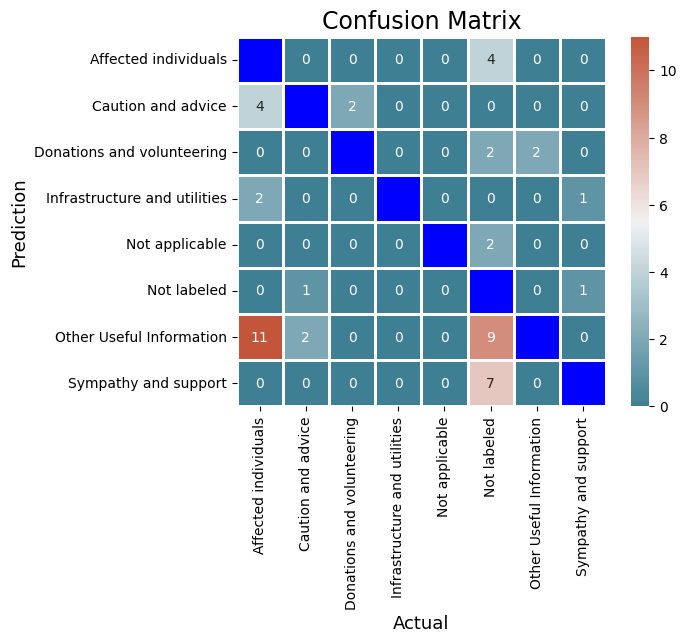

In [72]:
# Create a confusion matrix with InformationType Parsed_Pred_InformationType_v9
# confusion_matrix = confusion_matrix(testing_df['Pred_InformationType_v9'], testing_df['Parsed_Pred_InformationType_v9'])
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import seaborn as sns
import matplotlib.pyplot as plt

#Create the NumPy array for actual and predicted labels.
actual    = testing_df2['InformationType']
predicted = testing_df2['Parsed_Pred_InformationType_v9']

#compute the confusion matrix.
cm = confusion_matrix(actual,predicted)

#Create the unique labels
labels = unique_labels(actual,predicted)

# Create a mask that selects the diagonal elements
mask = np.eye(len(labels), dtype=bool)

# Create a color map with blue off-diagonal elements and green diagonal elements
cmap = sns.diverging_palette(220, 20, as_cmap=True)
cmap.set_bad("blue")
cmap.set_over("green")


#Plot the confusion matrix.
sns.heatmap(cm,
            annot=True,
            fmt='g',
            xticklabels=labels,
            yticklabels=labels,
            mask=mask,
            cmap=cmap,
            square=True, linewidths=1, linecolor='white')
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()


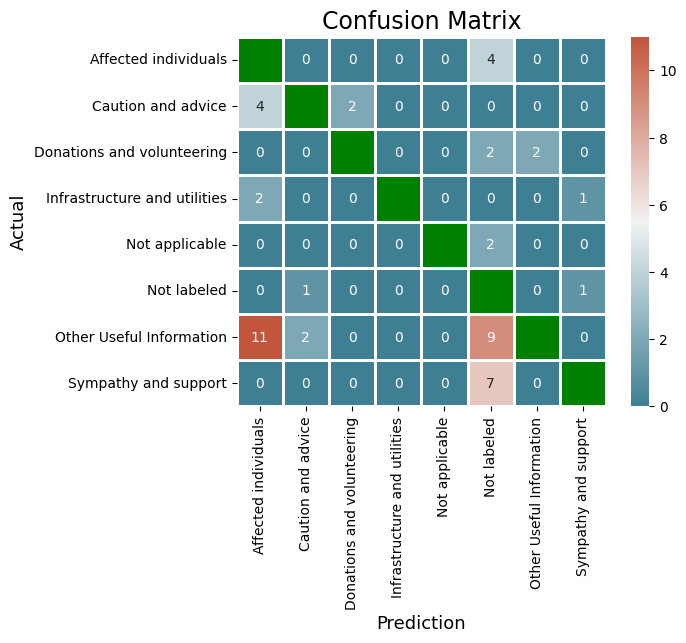

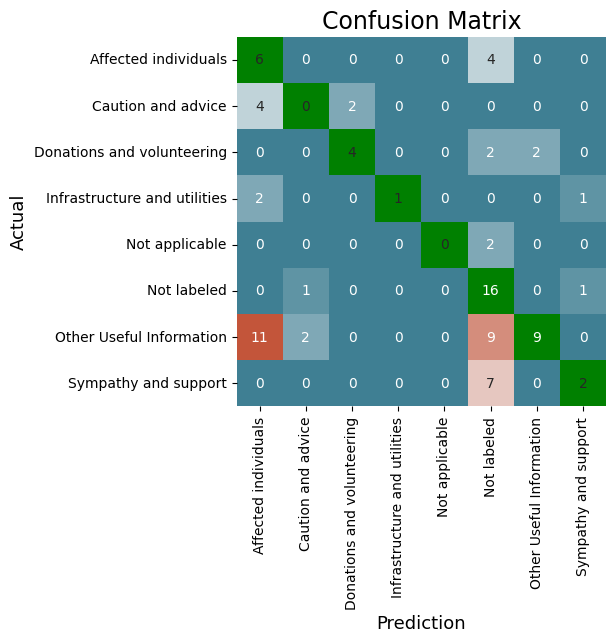

In [73]:
# Create a confusion matrix with InformationType Parsed_Pred_InformationType_v9
# confusion_matrix = confusion_matrix(testing_df['Pred_InformationType_v9'], testing_df['Parsed_Pred_InformationType_v9'])
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import seaborn as sns
import matplotlib.pyplot as plt

#Create the NumPy array for actual and predicted labels.
actual    = testing_df2['InformationType']
predicted = testing_df2['Parsed_Pred_InformationType_v9']

#compute the confusion matrix.
cm = confusion_matrix(actual,predicted)

#Create the unique labels
labels = unique_labels(actual,predicted)

# Create a mask that selects the diagonal elements
mask = np.eye(len(labels), dtype=bool)

# Create a color map with blue off-diagonal elements and green diagonal elements
cmap = sns.diverging_palette(220, 20, as_cmap=True)
cmap.set_bad("green")
cmap.set_over("green")


#Plot the confusion matrix.
sns.heatmap(cm,
            annot=True,
            fmt='g',
            xticklabels=labels,
            yticklabels=labels,
            mask=mask,
            cmap=cmap,
            square=True, linewidths=1, linecolor='white')
plt.ylabel('Actual',fontsize=13)
plt.xlabel('Prediction',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()


fig = plt.figure()
sns.heatmap(cm,
            annot=True,
            fmt='g',
            # xticklabels=labels,
            # yticklabels=labels,
            mask=~mask,
            cmap='Blues',
            square=True, linewidths=1, linecolor='white',  cbar=False)
sns.heatmap(cm,
            annot=True,
            fmt='g',
            xticklabels=labels,
            yticklabels=labels, mask=mask, cmap=cmap, cbar=False)
plt.ylabel('Actual',fontsize=13)
plt.xlabel('Prediction',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()

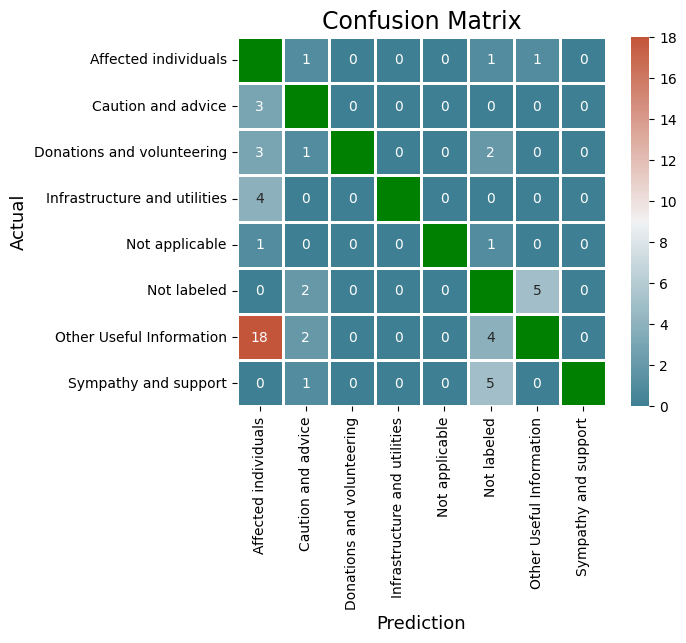

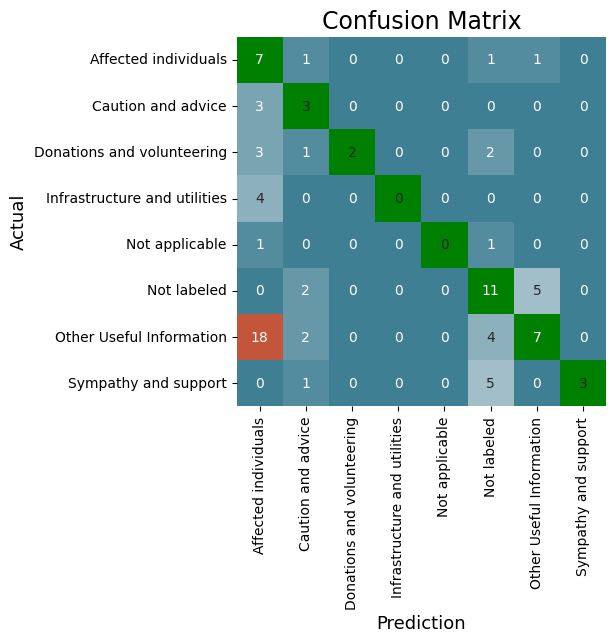

In [79]:
# Create a confusion matrix with InformationType Parsed_Pred_InformationType_Baseline
# confusion_matrix = confusion_matrix(testing_df['Pred_InformationType_v9'], testing_df['Parsed_Pred_InformationType_v9'])
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import seaborn as sns
import matplotlib.pyplot as plt

#Create the NumPy array for actual and predicted labels.
actual    = testing_df2['InformationType']
predicted = testing_df2['Parsed_Pred_InformationType_Baseline']

#compute the confusion matrix.
cm = confusion_matrix(actual,predicted)

#Create the unique labels
labels = unique_labels(actual,predicted)

# Create a mask that selects the diagonal elements
mask = np.eye(len(labels), dtype=bool)

# Create a color map with blue off-diagonal elements and green diagonal elements
cmap = sns.diverging_palette(220, 20, as_cmap=True)
cmap.set_bad("green")
cmap.set_over("green")


#Plot the confusion matrix.
sns.heatmap(cm,
            annot=True,
            fmt='g',
            xticklabels=labels,
            yticklabels=labels,
            mask=mask,
            cmap=cmap,
            square=True, linewidths=1, linecolor='white')
plt.ylabel('Actual',fontsize=13)
plt.xlabel('Prediction',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()


fig = plt.figure()
sns.heatmap(cm,
            annot=True,
            fmt='g',
            # xticklabels=labels,
            # yticklabels=labels,
            mask=~mask,
            cmap='Blues',
            square=True, linewidths=1, linecolor='white',  cbar=False)
sns.heatmap(cm,
            annot=True,
            fmt='g',
            xticklabels=labels,
            yticklabels=labels, mask=mask, cmap=cmap, cbar=False)
plt.ylabel('Actual',fontsize=13)
plt.xlabel('Prediction',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()

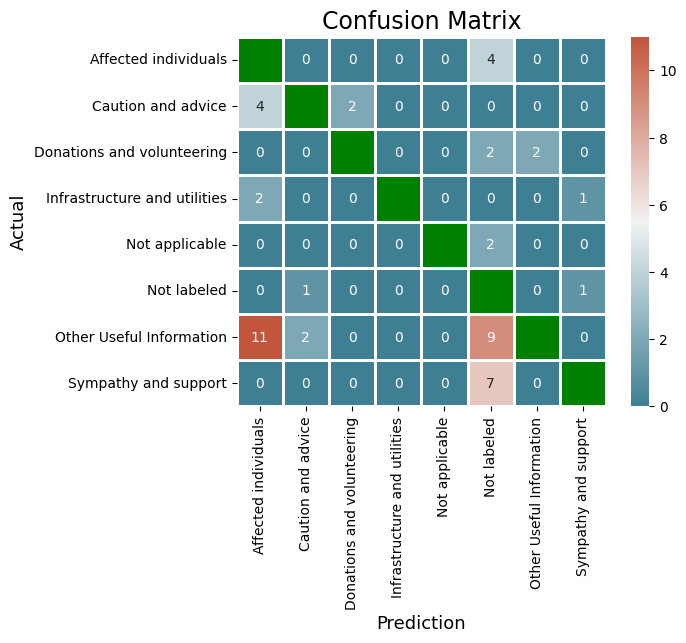

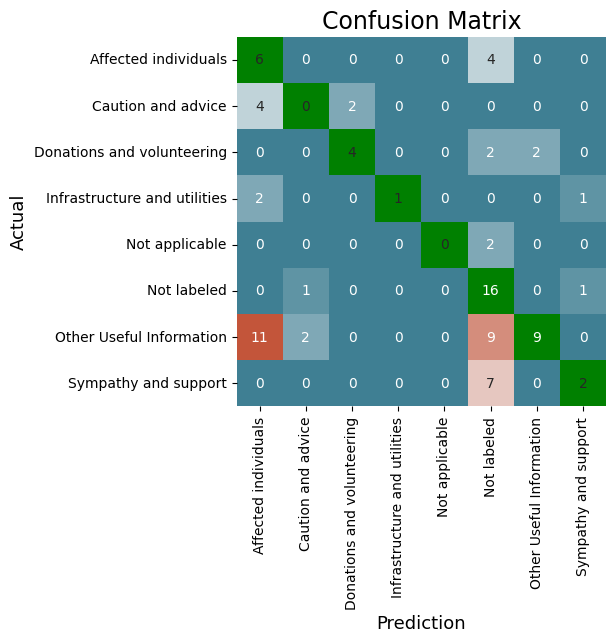

In [ ]:
# Create a confusion matrix with InformationType Parsed_Pred_InformationType_v9
# confusion_matrix = confusion_matrix(testing_df['Pred_InformationType_v9'], testing_df['Parsed_Pred_InformationType_v9'])
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import seaborn as sns
import matplotlib.pyplot as plt

#Create the NumPy array for actual and predicted labels.
actual    = testing_df2['InformationType']
predicted = testing_df2['Parsed_Pred_InformationType_v9']

#compute the confusion matrix.
cm = confusion_matrix(actual,predicted)

#Create the unique labels
labels = unique_labels(actual,predicted)

# Create a mask that selects the diagonal elements
mask = np.eye(len(labels), dtype=bool)

# Create a color map with blue off-diagonal elements and green diagonal elements
cmap = sns.diverging_palette(220, 20, as_cmap=True)
cmap.set_bad("green")
cmap.set_over("green")


#Plot the confusion matrix.
sns.heatmap(cm,
            annot=True,
            fmt='g',
            xticklabels=labels,
            yticklabels=labels,
            mask=mask,
            cmap=cmap,
            square=True, linewidths=1, linecolor='white')
plt.ylabel('Actual',fontsize=13)
plt.xlabel('Prediction',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()


fig = plt.figure()
sns.heatmap(cm,
            annot=True,
            fmt='g',
            # xticklabels=labels,
            # yticklabels=labels,
            mask=~mask,
            cmap='Blues',
            square=True, linewidths=1, linecolor='white',  cbar=False)
sns.heatmap(cm,
            annot=True,
            fmt='g',
            xticklabels=labels,
            yticklabels=labels, mask=mask, cmap=cmap, cbar=False)
plt.ylabel('Actual',fontsize=13)
plt.xlabel('Prediction',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()

In [74]:
len(testing_df2.index)

88

# Test